In [1]:
 %config IPCompleter.greedy=True

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk

# SPAM/HAM Dataset Analysis

## Importing Dataset

In [20]:
dataset_path = "../dataset/spam.csv"
df = pd.read_csv(dataset_path, sep=",", encoding="latin-1")
df = df.rename(columns={"v1": "class", "v2": "text"})
df = df.drop(df.columns[2:], axis=1)

In [21]:
df.head()

,class,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Preparing dataset : Tokenizing and deleting stopwords



Deleting "stop word" (most common words that don't give much insight on the data).

In [22]:
nltk.download('stopwords')

stopwords = nltk.corpus.stopwords.words('english')
tokenizer = nltk.RegexpTokenizer(r'\w+')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andrewpouret/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
"""
def tokenize_sentence_filter_stop_words(sentence):
    return [token.lower() for token in  tokenizer.tokenize(sentence)
                if token not in stopwords]


import time

tokenized_paragraphs = []

start_time = time.time()

for i in df["paragraph"]:
    tokenized_paragraphs.append(tokenize_sentence_filter_stop_words(i))
    
print("--- Tokenized paragraphs in %s seconds ---" % (time.time() - start_time))
"""

'\ndef tokenize_sentence_filter_stop_words(sentence):\n    return [token.lower() for token in  tokenizer.tokenize(sentence)\n                if token not in stopwords]\n\n\nimport time\n\ntokenized_paragraphs = []\n\nstart_time = time.time()\n\nfor i in df["paragraph"]:\n    tokenized_paragraphs.append(tokenize_sentence_filter_stop_words(i))\n    \nprint("--- Tokenized paragraphs in %s seconds ---" % (time.time() - start_time))\n'

## Displaying most used Words (Word Cloud)

In [24]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    
    get_top_n_words(["I love Python", "Python is a language programming", "Hello world", "I love the world"]) -> 
    [('python', 2),
     ('world', 2),
     ('love', 2),
     ('hello', 1),
     ('is', 1),
     ('programming', 1),
     ('the', 1),
     ('language', 1)]
    """
    vec = CountVectorizer(stop_words=frozenset(stopwords)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]



,class,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
6,ham,Even my brother is not like to speak with me. ...
...,...,...
5565,ham,Huh y lei...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


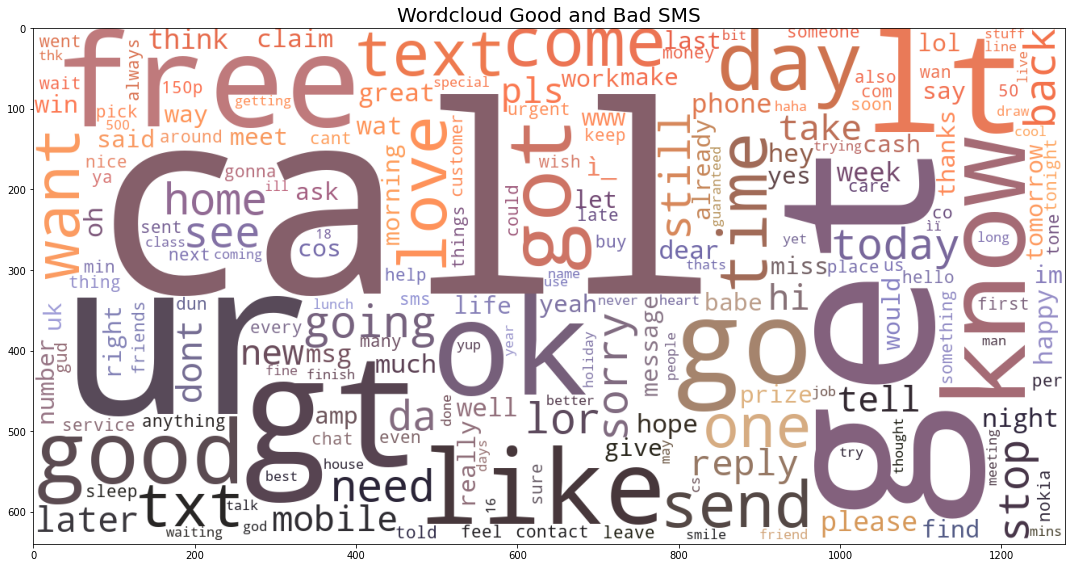

In [36]:
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator


def generate_word_cloud(df_col, title="wordcloud"):
    word_frequencies = get_top_n_words(df_col)    
    
    char_mask = np.array(Image.open("../docs/berkeley-background.jpeg")) # you can choose your own image for the colors
    image_colors = ImageColorGenerator(char_mask)

    word_frequencies_dict = {}

    for word, freq in word_frequencies:
        word_frequencies_dict[word] = freq


    wc = WordCloud(background_color="white", max_words=200, width=10000, height=1000, mask=char_mask, random_state=1)
    wc.generate_from_frequencies(word_frequencies_dict)
    # to recolour the image
    fig = plt.gcf()
    plt.title(title, fontsize=20)
    fig.set_size_inches(18.5, 10.5)
    plt.imshow(wc.recolor(color_func=image_colors))
    
generate_word_cloud(df["text"], "Wordcloud Good and Bad SMS")

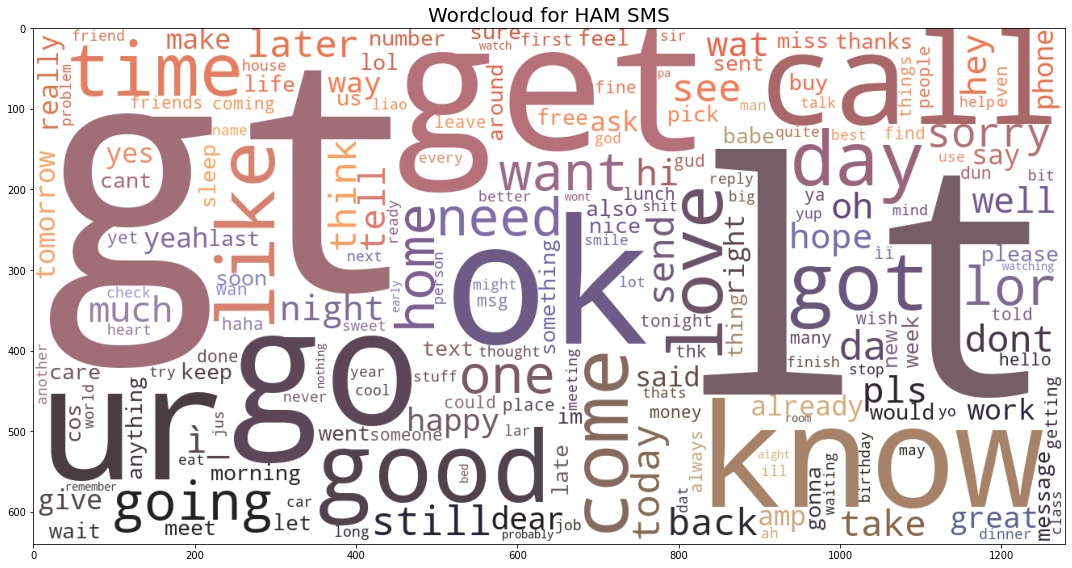

In [39]:
generate_word_cloud(df[df["class"] == "ham"]["text"], "Wordcloud for HAM SMS")

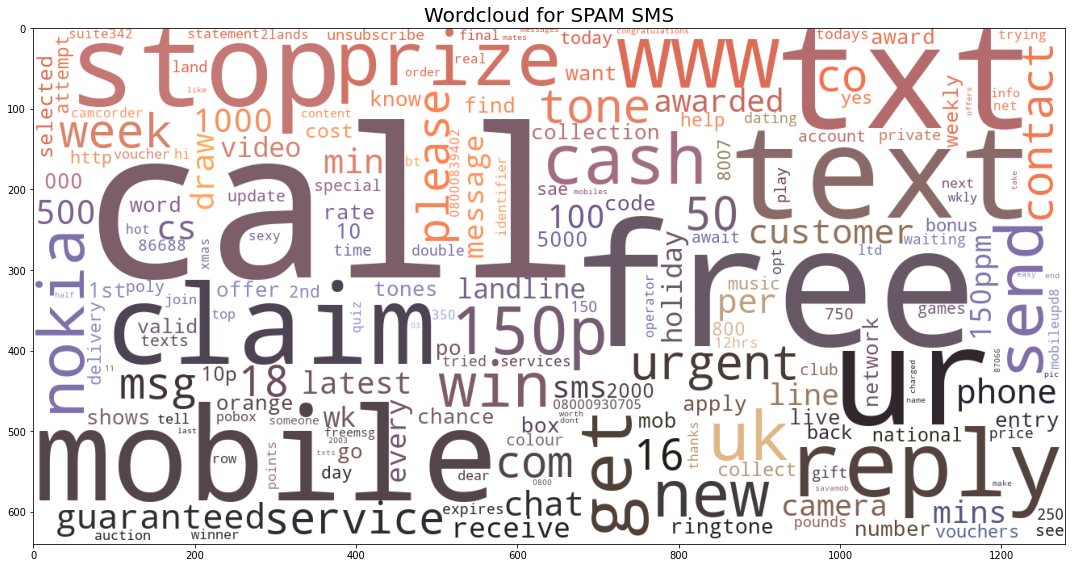

In [38]:
generate_word_cloud(df[df["class"] == "spam"]["text"], "Wordcloud for SPAM SMS")

## Theme Analysis

In [40]:
from sklearn.feature_extraction.text import CountVectorizer

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=10000, stop_words=frozenset(stopwords))
tf = tf_vectorizer.fit_transform(df["text"])


### Using LDA

In [41]:
from sklearn.decomposition import LatentDirichletAllocation

n_topics = 10

lda = LatentDirichletAllocation(
        n_components=n_topics, 
        max_iter=5, 
        learning_method='online', 
        learning_offset=50.,
        random_state=0)

lda.fit(tf)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, random_state=0)

In [42]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, tf_vectorizer.get_feature_names(), no_top_words)

Topic 0:
gt lt know like get yeah got sure buy need
Topic 1:
time oh first sleep work night late anything hey yet
Topic 2:
ok going home ì_ need dont tomorrow today come mins
Topic 3:
lor go got wat already wan dun back ok ìï
Topic 4:
da day said make happy nice went right babe birthday
Topic 5:
ur get take hi new great txt come send week
Topic 6:
much say pick cant one always think never better god
Topic 7:
good love get give life dear thanks well want morning
Topic 8:
call pls sorry later send number please yes cool message
Topic 9:
call free mobile prize claim www text cash txt contact
